<a href="https://colab.research.google.com/github/rahuldave/LearningJax/blob/main/Jax_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An application of vmap and pmap

This notebook is a stripped down version of https://www.kaggle.com/code/aakashnain/tf-jax-tutorials-part-8-vmap-pmap/notebook . This is Aakkash Nain's super nice Kaggle set of tutorials on tensorflow anf jax.

It illustrates the use on Jax random numbers and `vmap` and pmap` to create a simple little data augmentation library for image manipulation.

In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

setup stuff for runtime TPU or CPU

In [2]:
USE_TPU = True

if USE_TPU:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  # x8 cpu devices  
  import os
  os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'

In [3]:
import jax
print(repr(jax.devices()))
num_replicas = len(jax.devices())

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


In [4]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import make_jaxpr

We're going to be writing a data augmentation library which applies transformations to images. To test our code, we'll download a small selection of images...

In [5]:
!wget "https://i.imgur.com/Bvro0YD.png" -O elephant.png
!wget "https://images-eu.ssl-images-amazon.com/images/I/A1WuED4KiRL.jpg" -O cat.jpg
!wget "https://upload.wikimedia.org/wikipedia/commons/1/18/Dog_Breeds.jpg" -O dog.jpg
!wget "https://upload.wikimedia.org/wikipedia/commons/1/1e/The_Korean_Lucky_Bird_%28182632069%29.jpeg" -O bird.jpg
!wget "https://upload.wikimedia.org/wikipedia/commons/e/ea/Vervet_Monkey_%28Chlorocebus_pygerythrus%29.jpg" -O monkey.jpg
!wget "https://upload.wikimedia.org/wikipedia/commons/f/fa/Puppy.JPG" -O puppy.jpg
!wget "https://upload.wikimedia.org/wikipedia/commons/2/2c/Lion-1.jpg" -O lion.jpg
!wget "https://upload.wikimedia.org/wikipedia/commons/4/41/Siberischer_tiger_de_edit02.jpg" -O tiger.jpg

--2022-06-09 06:06:25--  https://i.imgur.com/Bvro0YD.png
Resolving i.imgur.com (i.imgur.com)... 151.101.184.193
Connecting to i.imgur.com (i.imgur.com)|151.101.184.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4217496 (4.0M) [image/png]
Saving to: ‘elephant.png’

elephant.png        100%[===================>]   4.02M  --.-KB/s    in 0.07s   

2022-06-09 06:06:25 (56.1 MB/s) - ‘elephant.png’ saved [4217496/4217496]

--2022-06-09 06:06:25--  https://images-eu.ssl-images-amazon.com/images/I/A1WuED4KiRL.jpg
Resolving images-eu.ssl-images-amazon.com (images-eu.ssl-images-amazon.com)... 151.101.1.16, 151.101.65.16, 151.101.129.16, ...
Connecting to images-eu.ssl-images-amazon.com (images-eu.ssl-images-amazon.com)|151.101.1.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1137270 (1.1M) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]   1.08M  --.-KB/s    in 0.05s   

2022-06-09 06:06:25 (21.4 MB/s) -

## 1: Loading the images

We'll now write some code to read these images into memory, creating a large array..

In [6]:
import glob
import cv2

def read_images(size=(800, 800)):
    """Read jpg/png images from the disk.
    
    Args:
        size: Size to be used while resizing
    Returns:
        A JAX array of images
    """
    png_images = sorted(glob.glob("*.png"))
    jpg_images = sorted(glob.glob("*.jpg"))
    all_images = png_images + jpg_images
    
    images = []
    
    for img in all_images:
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size)
        images.append(img)
        
    return jnp.array(images)


# Read and resize
images = read_images()
print("Total number of images: ", len(images))

Total number of images:  8


In [7]:
images.shape

(8, 800, 800, 3)

We have 8 images, so that becomes our batch dimension. Perpendicular to this dimension is each image. We've resized the images to 800x800, and converted colors to RGB, so each image is 800x800x3 (where the last dimension is the channel dimension).

This situation can be illustrated as so: every image is a 800x800x3 tensor:

![](https://i.imgur.com/jEkGXKe.jpg)

Many images, as in out previous examples of vmap are arranged in the "0" axis, to construct a higher order tensor:

![](https://i.imgur.com/LqZvo01.jpg)

## 2: Transforming one image

Lets see one of these images and make a transformation on it. With mapping in jax, you always want to implement the simplest case first. We use the numpy function `rot90` to implement a rotation...

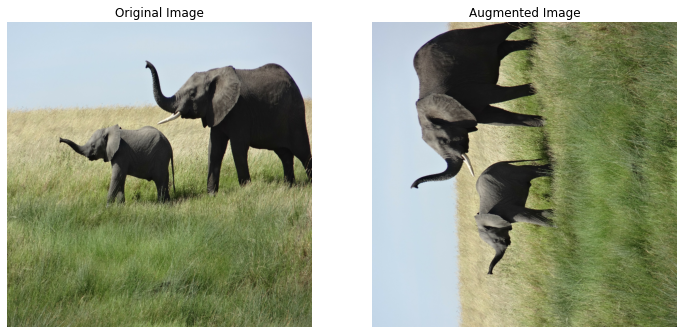

In [8]:
# Get an image
img = images[0]
img_copy = img.copy()

# Pass the image copy to augmentation pipeline
augmented = jnp.rot90(img_copy, axes=(0, 1))

# Plot the original image and the augmented image
_, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].imshow(img)
ax[0].axis("off")
ax[0].set_title("Original Image")

ax[1].imshow(augmented)
ax[1].axis("off")
ax[1].set_title("Augmented Image")

plt.show()

In [9]:
# Utility function for plotting the images
def plot_images(images, batch_size, num_cols=4, figsize=(15, 8), title="Images "):
    num_rows = batch_size // num_cols
    
    _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    for i, img in enumerate(images):
        ax[i // num_cols, i % num_cols].imshow(images[i])
        ax[i // num_cols, i % num_cols].axis("off")
        #ax[i // num_cols, i % num_cols].set_title(str(i+1))
        
    plt.tight_layout()
    plt.suptitle(title, x=0.5, y=1.0, fontsize=16)
    plt.show()

We can use the above utility function to plot all our 8 images

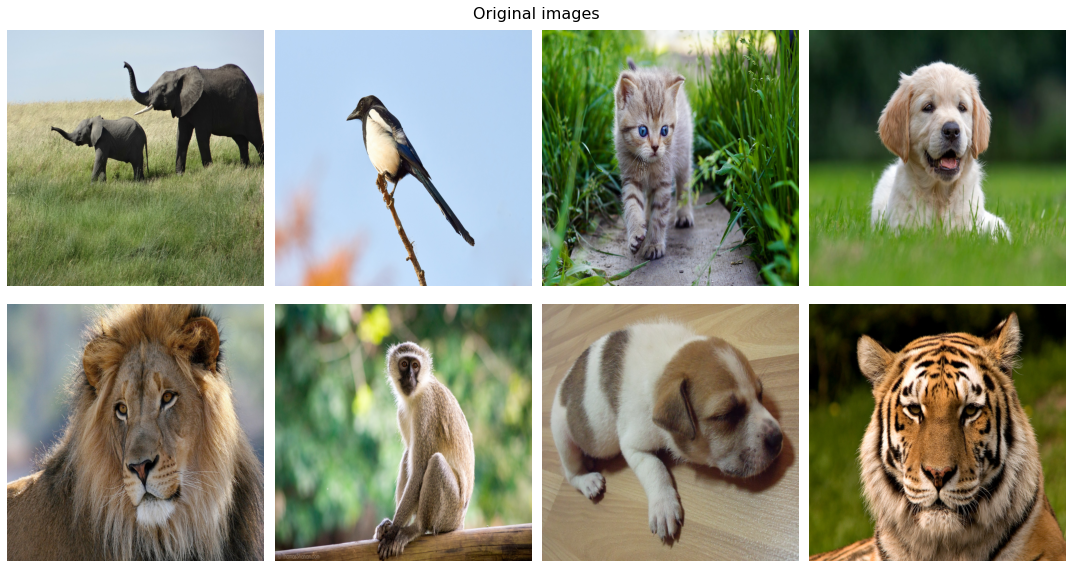

In [10]:
plot_images(images, batch_size=8, title="Original images")

## 3: `vmap` to transform all images

Since we have a batch axis already pre-provided for us, it is almost trivial to make a vmap over the batch dimension and use the same code to process each image.

The `in_axes` code is not needed here, because the firat dimension is the batch axis, and we want to `vmap` along it.

In [11]:
from jax import vmap, jit
augmented = jit(vmap(jnp.rot90, in_axes=(0)))(images)

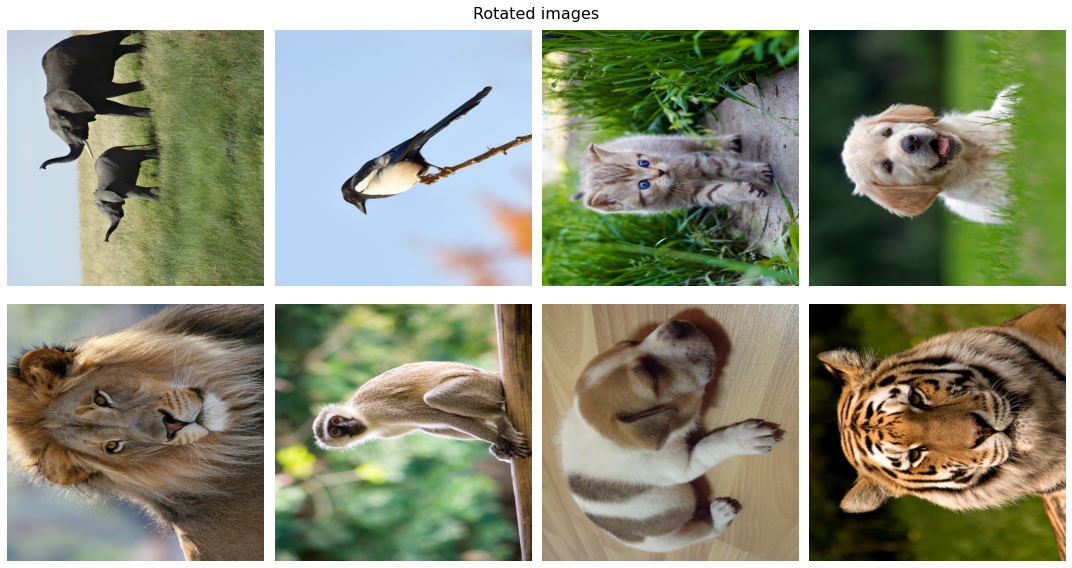

In [12]:
plot_images(augmented, batch_size=8, title="Rotated images")

Why has the original `images` array not changed? (see below)

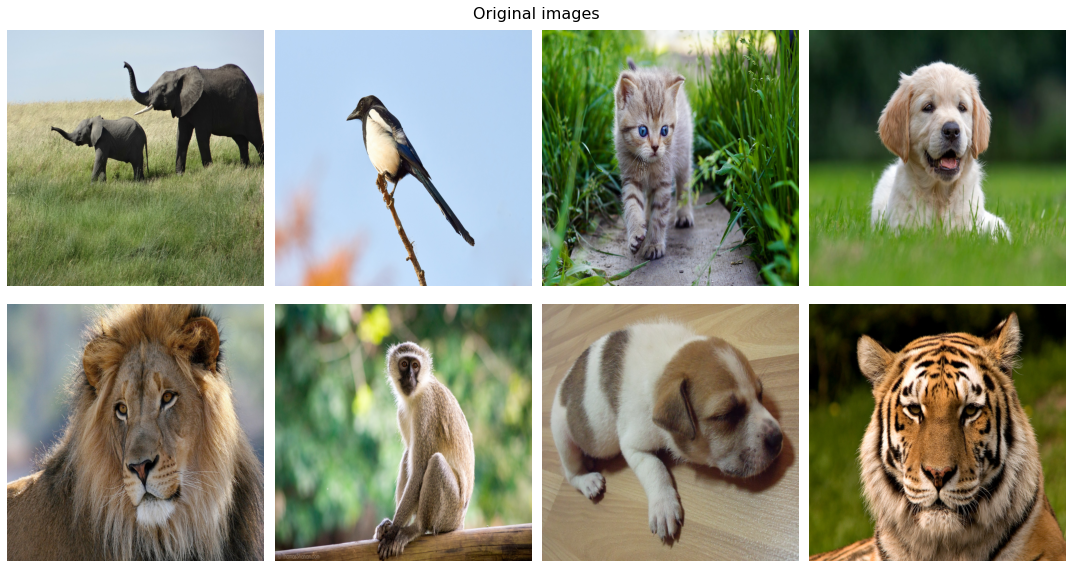

In [13]:
plot_images(images, batch_size=8, title="Original images")

## 4: Creating a `vmap` based augmentation library

We want to augment the input batch. When we augment, we dont want everything to have the same transformation. Thus we introduce randomness...

In [14]:
from jax import random
def rotate_90(img):
    """Rotates an image by 90 degress k times."""
    return jnp.rot90(img, k=1, axes=(0, 1))


def identity(img):
    """Returns an image as it is."""
    return img


def flip_left_right(img):
    """Flips an image left/right direction."""
    return jnp.fliplr(img)


def flip_up_down(img):
    """Flips an image in up/down direction."""
    return jnp.flipud(img)


def random_rotate(img, rotate):
    """Randomly rotate an image by 90 degrees.
    
    Args:
        img: Array representing the image
        rotate: Boolean for rotating or not
    Returns:
        Rotated or an identity image
    """

    return jax.lax.cond(rotate, rotate_90, identity, img)


def random_horizontal_flip(img, flip):
    """Randomly flip an image vertically.
    
    Args:
        img: Array representing the image
        flip: Boolean for flipping or not
    Returns:
        Flipped or an identity image
    """
    
    return jax.lax.cond(flip, flip_left_right, identity, img)
    
    
def random_vertical_flip(img, flip):
    """Randomly flip an image vertically.
    
    Args:
        img: Array representing the image
        flip: Boolean for flipping or not
    Returns:
        Flipped or an identity image
    """
    
    return jax.lax.cond(flip, flip_up_down, identity, img)


# Get the jitted version of our augmentation functions
random_rotate_jitted = jit(vmap(random_rotate, in_axes=(0, 0)))
random_horizontal_flip_jitted = jit(vmap(random_horizontal_flip, in_axes=(0, 0)))
random_vertical_flip_jitted = jit(vmap(random_vertical_flip, in_axes=(0, 0)))


def augment_images(images, key):
    """Augment a batch of input images.
    
    Args:
        images: Batch of input images as a jax array
        key: Seed/Key for random functions for generating booleans
    Returns:
        Augmented images with the same shape as the input images
    """
    
    batch_size = len(images)
    
    # 1. Rotation
    key, subkey = random.split(key)
    rotate = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_rotate_jitted(images, rotate)
    
    # 2. Flip horizontally
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_horizontal_flip_jitted(augmented, flip)
    
    # 3. Flip vertically
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_vertical_flip_jitted(augmented, flip)
    
    return augmented.block_until_ready()

Some things about this code are worth noticing:

1. All our functions take a 0/1 choice to indicate whether we should do the transformation. This boolean is randomly chosen
2. to choose this boolean we throw a new random key by doing a split and then using `randint` with the key from the split.
3. we sequentially try a rotation, horizontal flip, and vertical flip. Depending on the random bit this may or may not happen
4. We `block_until_ready` to mahe sure the augmentation is actually carried out.

Our `in_axes` indicates that we vmap over the 0th axis of both our arguments. The first argument referes to the tensor, so here we are vmapping over the batch axis. Our second argument referes to a batch-size length vector of booleans, so we must vmap over this too to pick up the boolean associated with the sample in the batch.

In [15]:
key=random.PRNGKey(0)
augmented = augment_images(images, key)

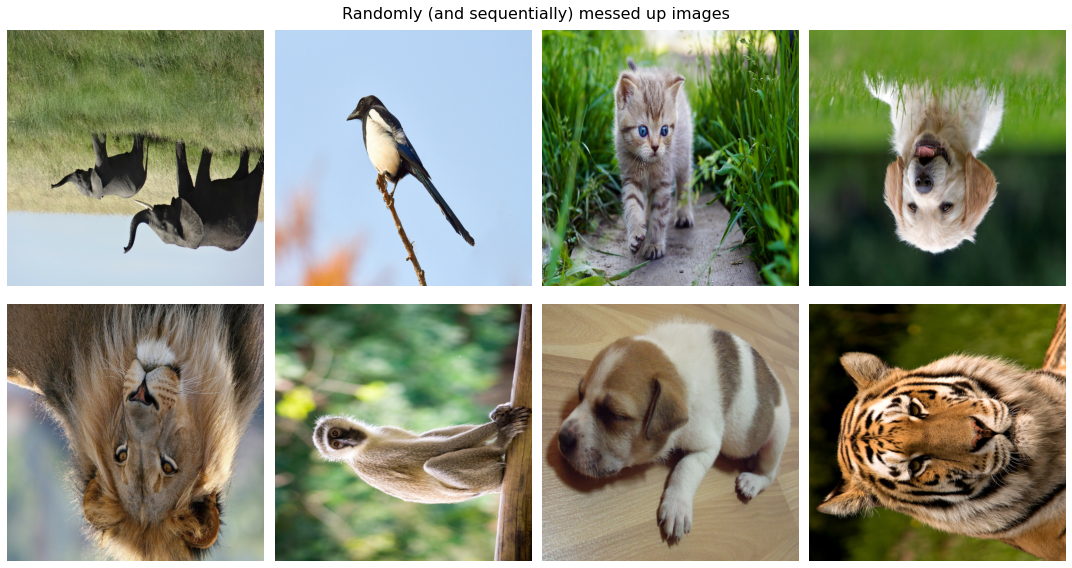

In [16]:
plot_images(augmented, batch_size=8, title="Randomly (and sequentially) messed up images")

## 5: `pmap` based parallelization

If we have a lot of images, why not use multiple gpus, cpus, or tpus to do the images in parallel?

Lets create an artificial big stack by replicating these 8 images `nul_replicas` times.

Then we'll need to get a key for each of these replicas.

In [17]:
# Generate a big batch of 8*num_replicas
big_batch_images = jnp.stack([images for i in range(num_replicas)])
print("Number of images in batch: ", big_batch_images.shape[0])

# Generate a batch of keys as well as the augment_images
# function accepts a key as well
key = random.PRNGKey(123)
print(key)
big_batch_keys = [key]

for i in range(num_replicas - 1):
    key, subkey = random.split(key)
    big_batch_keys.append(key)
print(big_batch_keys)    
big_batch_keys = jnp.stack(big_batch_keys)
big_batch_keys

Number of images in batch:  8
[  0 123]
[DeviceArray([  0, 123], dtype=uint32), DeviceArray([1896456402,   17229315], dtype=uint32), DeviceArray([1629931467,  253346090], dtype=uint32), DeviceArray([2627000397, 1518189144], dtype=uint32), DeviceArray([2078539884, 3443489024], dtype=uint32), DeviceArray([ 279746543, 1407646903], dtype=uint32), DeviceArray([ 642702015, 2963698884], dtype=uint32), DeviceArray([3782758901, 1229027166], dtype=uint32)]


DeviceArray([[         0,        123],
             [1896456402,   17229315],
             [1629931467,  253346090],
             [2627000397, 1518189144],
             [2078539884, 3443489024],
             [ 279746543, 1407646903],
             [ 642702015, 2963698884],
             [3782758901, 1229027166]], dtype=uint32)

In [20]:
big_batch_images.shape, big_batch_keys.shape

((8, 8, 800, 800, 3), (8, 2))

Since `pmap` implicitly does a `jit`, we need to remove the jitting from out augmentation pipeline.

In [18]:
# Get the jitted version of our augmentation functions
random_rotate_vmapped = vmap(random_rotate, in_axes=(0, 0))
random_horizontal_flip_vmapped = vmap(random_horizontal_flip, in_axes=(0, 0))
random_vertical_flip_vmapped = vmap(random_vertical_flip, in_axes=(0, 0))


def augment_images_nojit(images, key):
    """Augment a batch of input images.
    
    Args:
        images: Batch of input images as a jax array
        key: Seed/Key for random functions for generating booleans
    Returns:
        Augmented images with the same shape as the input images
    """
    
    batch_size = len(images)
    
    # 1. Rotation
    key, subkey = random.split(key)
    rotate = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_rotate_vmapped(images, rotate)
    
    # 2. Flip horizontally
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_horizontal_flip_vmapped(augmented, flip)
    
    # 3. Flip vertically
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_vertical_flip_vmapped(augmented, flip)
    
    return augmented

Now we `pmap`. Notice the `in_axes` is identical to `vmap`. Since we now have many more images, but as many keys as there are devices, the pmap along the second argument's 0th axis gives random keys to each device.

The stacking along the batch axis, has however opened up one more dimension. Instead of dealing with a batch of 64 images, the atck expands the array to have a new leading dimension. This ensures that the rest of the stuff goes per device. Since that array has a leading dimension of 8 (one per image), the vmap from before continues working!

In [21]:
from jax import pmap
pmapped_augment_images = pmap(augment_images_nojit, in_axes=(0, 0))
augmented_parallel = pmapped_augment_images(big_batch_images, big_batch_keys)

In [22]:
augmented_parallel

ShardedDeviceArray([[[[[195, 213, 233],
                       [196, 214, 234],
                       [195, 213, 233],
                       ...,
                       [ 45,  54,  25],
                       [ 44,  53,  24],
                       [ 49,  59,  29]],

                      [[195, 213, 233],
                       [197, 215, 235],
                       [196, 214, 234],
                       ...,
                       [ 64,  74,  40],
                       [ 40,  49,  18],
                       [ 53,  63,  33]],

                      [[196, 214, 234],
                       [195, 213, 232],
                       [195, 214, 232],
                       ...,
                       [106, 116,  78],
                       [ 71,  81,  47],
                       [ 52,  61,  28]],

                      ...,

                      [[188, 201, 220],
                       [188, 201, 220],
                       [188, 201, 220],
                       ...,
              

In [24]:
augmented_parallel.shape, type(augmented_parallel)

((8, 8, 800, 800, 3), jax.interpreters.pxla._ShardedDeviceArray)

Once again we have tensors sharded across 8 devices, with the local tensor on each device being a batch of 8 images.

To bring the images back from the devices, an op which wwaits for each device to complete, we simply reshape the first two dimensions into a 8*`num_replicas` dimension and we have all our images...

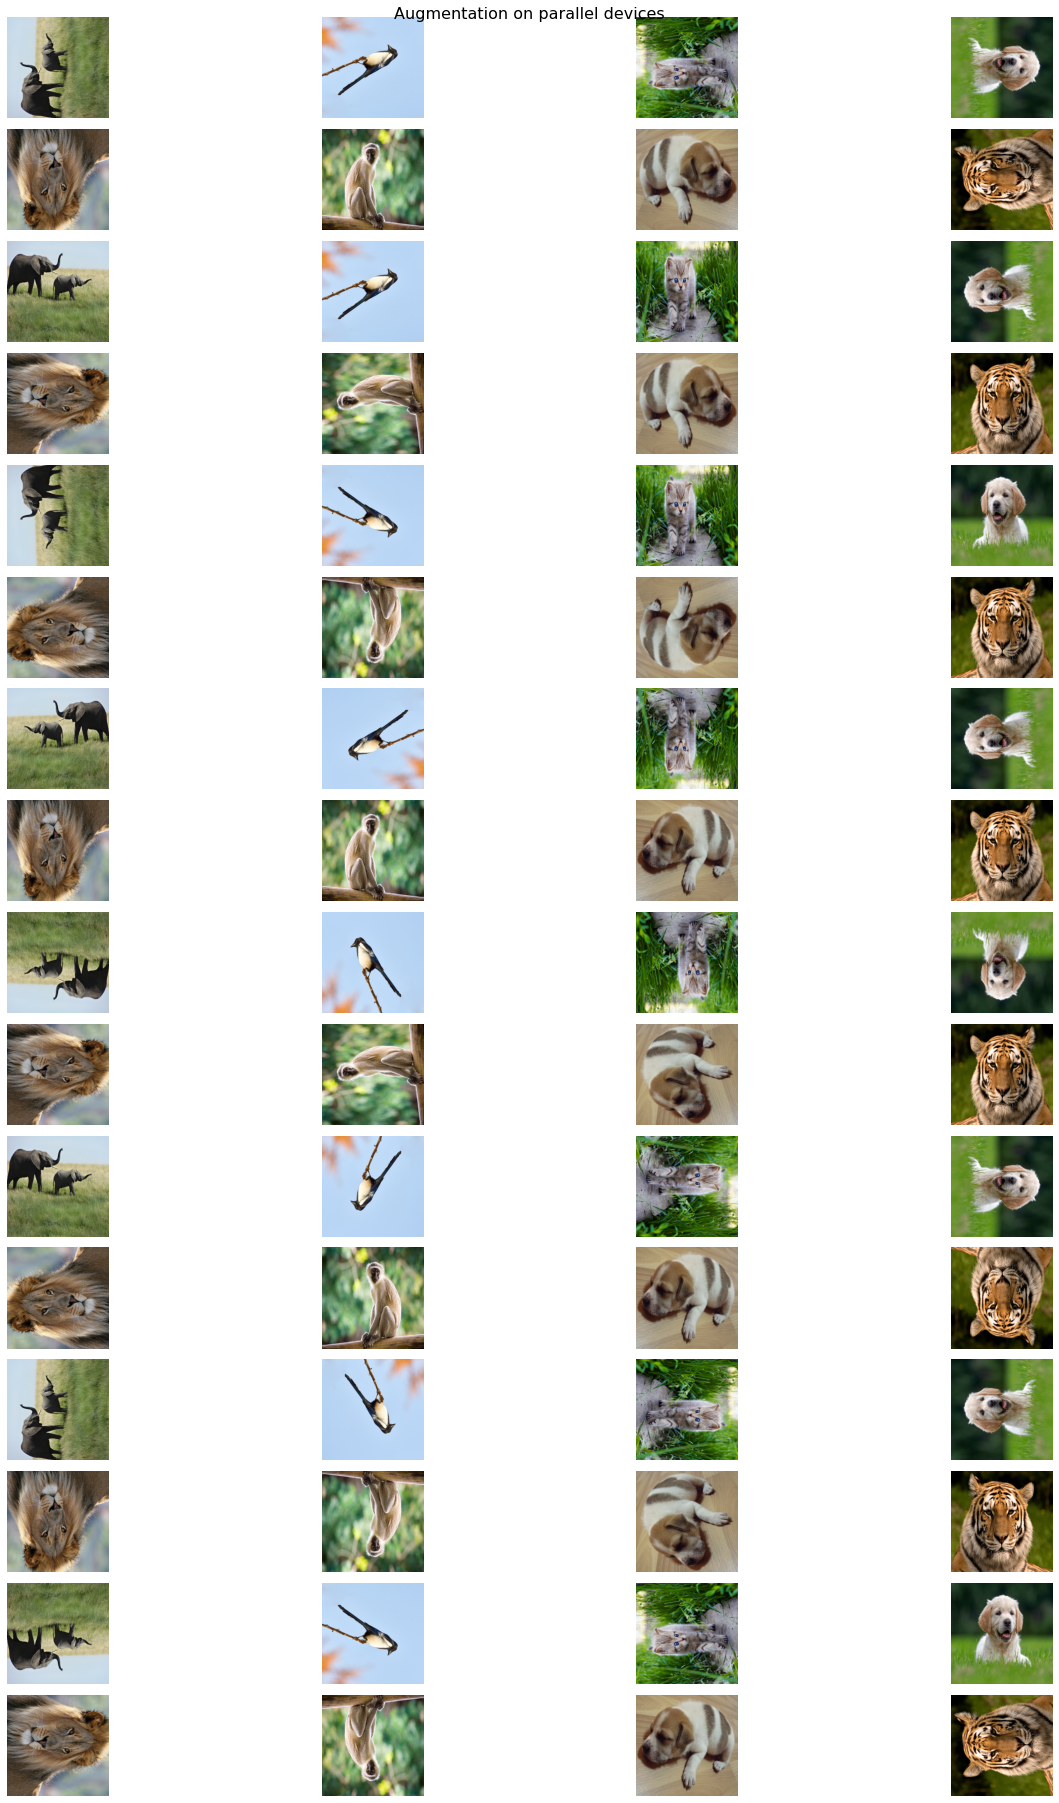

In [25]:
augmented_parallel_reduced = augmented_parallel.reshape(8*num_replicas, 800, 800, 3)
plot_images(augmented_parallel_reduced,
            batch_size=8*num_replicas,
            title="Augmentation on parallel devices",
            figsize=(20, 25)
           )